#Libraries

In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

2024-07-28 19:57:35.463 Python[74645:3888423] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import re
# Download NLTK stopwords
nltk.download('stopwords')

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Deep learning libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional, GRU, SpatialDropout1D, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Display libraries
from IPython.display import display, Image
from PIL import Image as PILImage

# gen
import os
import numpy as np
import polars as pl
import altair as alt
import warnings as war
war.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/girimanoharv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#DataProcessing

In [3]:
def load_and_rename(file_path, filename):
    full_path = f"{file_path}/{filename}"
    data = pl.read_csv(full_path, separator='\t')
    data.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"] 
    return data

# file paths'
file_path = '/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc'
train_filename = 'training/EI-oc-En-fear-train.txt'
dev_filename = 'development/2018-EI-oc-En-fear-dev.txt'
test_filename = 'test-gold/2018-EI-oc-En-fear-test-gold.txt'

# Read datasets and rename columns
data_train = load_and_rename(file_path, train_filename)
data_dev = load_and_rename(file_path, dev_filename)
data_test = load_and_rename(file_path, test_filename)

print(data_train.head(2))
print(data_dev.head(2))
print(data_test.head(1))


shape: (2, 4)
┌───────────────┬───────────────────────────────┬──────────────────┬───────────────────────────────┐
│ ID            ┆ Tweet                         ┆ Affect_Dimension ┆ Intensity_Class               │
│ ---           ┆ ---                           ┆ ---              ┆ ---                           │
│ str           ┆ str                           ┆ str              ┆ str                           │
╞═══════════════╪═══════════════════════════════╪══════════════════╪═══════════════════════════════╡
│ 2017-En-20968 ┆ @RockSolidShow @Pat_Francis   ┆ fear             ┆ 0: no fear can be inferred    │
│               ┆ #r…                           ┆                  ┆                               │
│ 2017-En-21816 ┆ @Its_just_Huong I will beat   ┆ fear             ┆ 1: low amount of fear can be  │
│               ┆ yo…                           ┆                  ┆ i…                            │
└───────────────┴───────────────────────────────┴──────────────────┴─────────

In [4]:
# Concatenate training and development data
mer_data_train = pl.concat([data_train, data_dev])

# Mapping of categorical values to numeric codes
def generate_intensity_mapping(word):
    return {
        f"0: no {word} can be inferred": 0,
        f"1: low amount of {word} can be inferred": 1,
        f"2: moderate amount of {word} can be inferred": 2,
        f"3: high amount of {word} can be inferred": 3
    }

e_word = "fear"
intensity_mapping = generate_intensity_mapping("fear")


data_train = data_train.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in data_train["Intensity_Class"]])
)

data_dev = data_dev.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in data_dev["Intensity_Class"]])
)

data_test = data_test.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in data_test["Intensity_Class"]])
)
mer_data_train = mer_data_train.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in mer_data_train["Intensity_Class"]])
)

print(mer_data_train.head(3))
print(data_test.head(3))

shape: (3, 4)
┌───────────────┬─────────────────────────────────┬──────────────────┬─────────────────┐
│ ID            ┆ Tweet                           ┆ Affect_Dimension ┆ Intensity_Class │
│ ---           ┆ ---                             ┆ ---              ┆ ---             │
│ str           ┆ str                             ┆ str              ┆ i64             │
╞═══════════════╪═════════════════════════════════╪══════════════════╪═════════════════╡
│ 2017-En-20968 ┆ @RockSolidShow @Pat_Francis #r… ┆ fear             ┆ 0               │
│ 2017-En-21816 ┆ @Its_just_Huong I will beat yo… ┆ fear             ┆ 1               │
│ 2017-En-21532 ┆ “What worries you masters you.… ┆ fear             ┆ 1               │
└───────────────┴─────────────────────────────────┴──────────────────┴─────────────────┘
shape: (3, 4)
┌───────────────┬─────────────────────────────────┬──────────────────┬─────────────────┐
│ ID            ┆ Tweet                           ┆ Affect_Dimension ┆ Intensity_C

In [5]:
#Intensity Class count occurrences with pie chart
intensity_counts = mer_data_train['Intensity_Class'].value_counts()

pie_chart = alt.Chart(intensity_counts).mark_arc(innerRadius=45).encode(
    theta=alt.Theta(field='count', type='quantitative', title='Count'),
    color=alt.Color(field='Intensity_Class', type='nominal', legend=alt.Legend(title="Intensity Class")),
    tooltip=['Intensity_Class', 'count']
).properties(
    title='Distribution of Intensity Classes'
).configure_title(
    fontSize=15,
    anchor='start'
)
pie_chart.display()

alt.Chart(...)

In [6]:
# Stop words
stop_words = set(stopwords.words('english'))
words_list = ['within', 'two', 'nine', 'zero', 'five', 'among', 'now', 'beside', 'seven', 'across', 'may', 'however', 'four', 'six', 'one', 'let', 'eight', 'three', 'ten', 'yet', 'also']
stop_words.update(words_list)
re_stop_words = re.compile(r"\b(" + "|".join(re.escape(word) for word in stop_words) + r")\b", re.I)


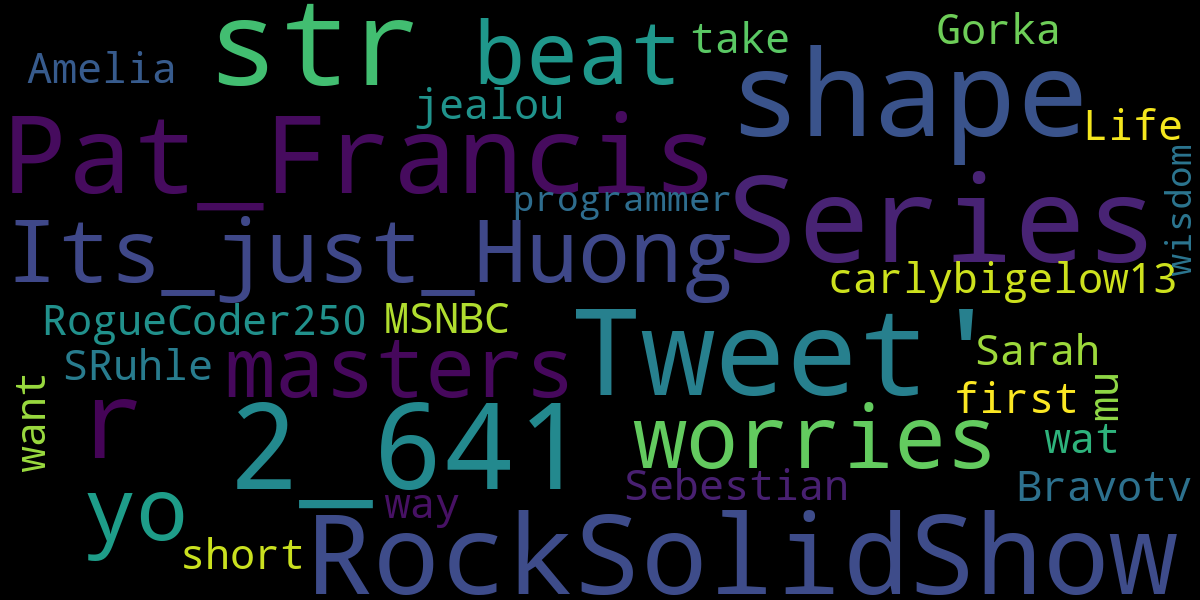

In [7]:
# Functions to Generate and display word clouds
def create_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random 
    ).generate(str(data))
    
    image_path = f"{title}.png"
    wordcloud.to_file(image_path)
    return image_path

def display_wordcloud(image_path, title):
    img = PILImage.open(image_path)
    display(img)

image_path = create_wordcloud(mer_data_train['Tweet'], f'figures/Most_Common_{e_word}_Words')
display_wordcloud(image_path, 'Most Common Words from the Whole Chorpus')


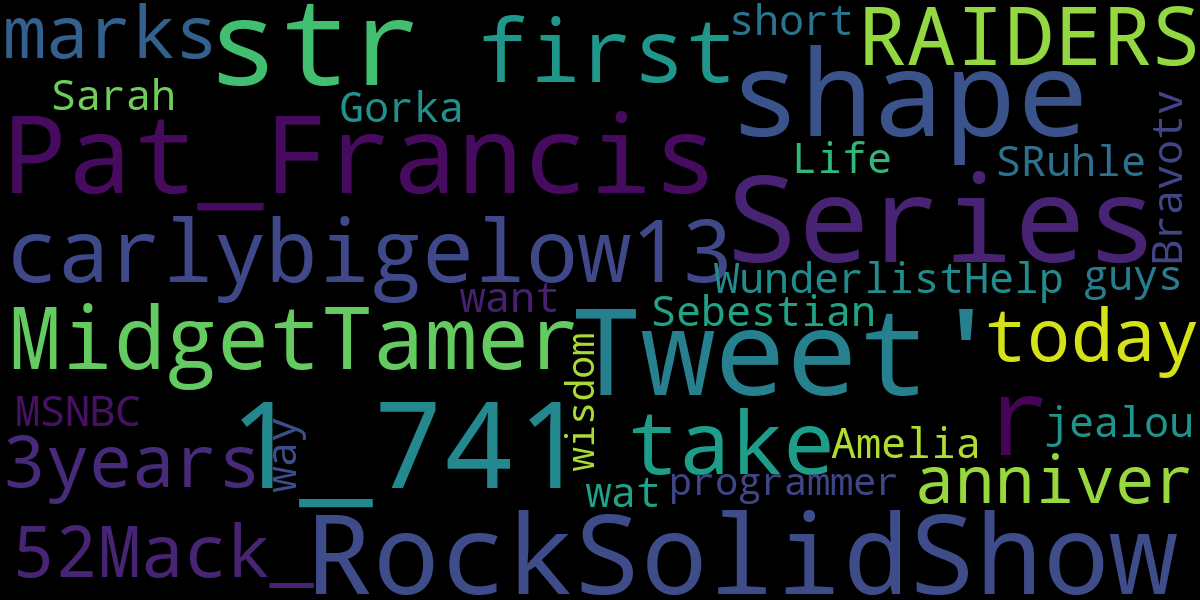

In [8]:
image_path = create_wordcloud(mer_data_train.filter(pl.col('Intensity_Class') == 0)['Tweet'], f'figures/No_{e_word}_Inferred')
display_wordcloud(image_path, 'No Anger Can Be Inferred')


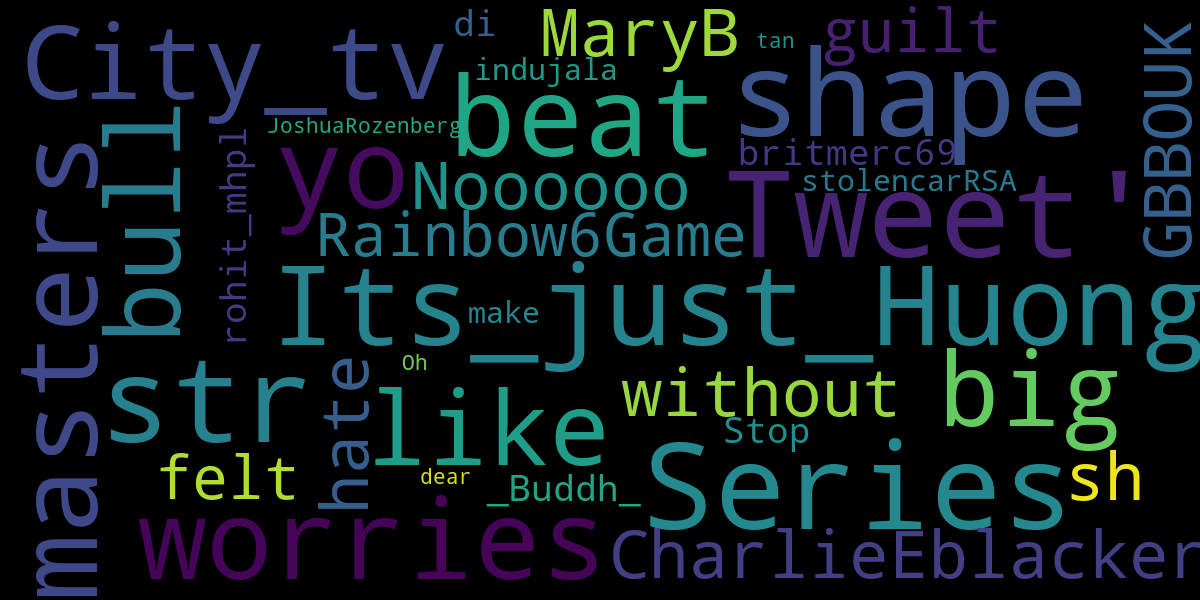

In [9]:
image_path = create_wordcloud(mer_data_train.filter(pl.col('Intensity_Class') == 1)['Tweet'], f'figures/Low_Amount_{e_word}_Inferred')
display_wordcloud(image_path, 'Low Amount of Anger Can Be Inferred')


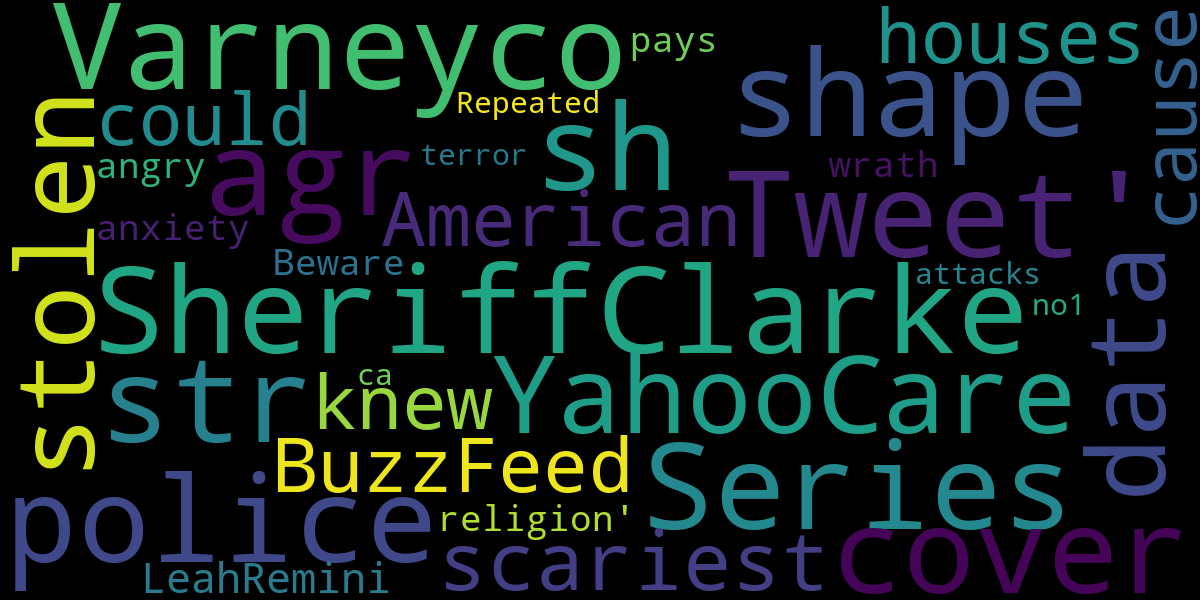

In [10]:
image_path = create_wordcloud(mer_data_train.filter(pl.col('Intensity_Class') == 2)['Tweet'], f'figures/Moderate_Amount_{e_word}_Inferred')
display_wordcloud(image_path, 'Moderate Amount of Anger Can Be Inferred')


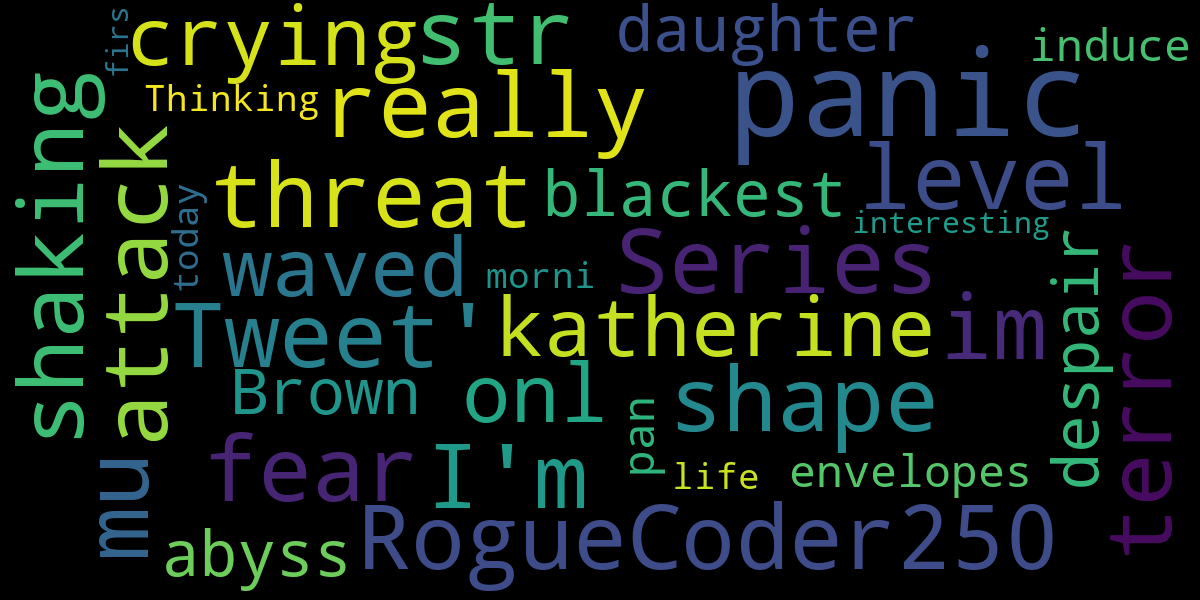

In [11]:
image_path = create_wordcloud(mer_data_train.filter(pl.col('Intensity_Class') == 3)['Tweet'], f'figures/High_Amount_{e_word}_Inferred')
display_wordcloud(image_path, 'High Amount of Anger Can Be Inferred')

In [12]:

def remove_stop_words(sentence):
    return re_stop_words.sub(" ", sentence)

mer_data_train = mer_data_train.with_columns(pl.col('Tweet').map_elements(remove_stop_words))
data_train = data_train.with_columns(pl.col('Tweet').map_elements(remove_stop_words))
data_test = data_test.with_columns(pl.col('Tweet').map_elements(remove_stop_words))
data_dev = data_dev.with_columns(pl.col('Tweet').map_elements(remove_stop_words))


In [13]:
data_test

ID,Tweet,Affect_Dimension,Intensity_Class
str,str,str,i64
"""2018-En-02626""","""@EdmundPAdamus ' horrific …","""fear""",1
"""2018-En-00320""","""@TuckerCarlson @krauthammer @F…","""fear""",0
"""2018-En-03973""","""@executivegoth tried free …","""fear""",0
"""2018-En-02615""","""@anya_sisi jail lots …","""fear""",1
"""2018-En-03312""",""" boss said another girl …","""fear""",0
…,…,…,…
"""2018-En-03629""","""Dear fellow #humans fall …","""fear""",0
"""2018-En-00270""",""" gave serious fright #sca…","""fear""",3
"""2018-En-00619""","""@bambustyk looks scared bu…","""fear""",0


In [14]:
stemmer = PorterStemmer()
# Stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    return " ".join(stemmer.stem(word) for word in sentence.split())

data_train = data_train.with_columns(pl.col('Tweet').map_elements(stemming))
data_test = data_test.with_columns(pl.col('Tweet').map_elements(stemming))
data_dev = data_dev.with_columns(pl.col('Tweet').map_elements(stemming))
mer_data_train = mer_data_train.with_columns(pl.col('Tweet').map_elements(stemming))


In [15]:
data_test

ID,Tweet,Affect_Dimension,Intensity_Class
str,str,str,i64
"""2018-En-02626""","""@edmundpadamus ' horrif irony;…","""fear""",1
"""2018-En-00320""","""@tuckercarlson @krauthamm @fox…","""fear""",0
"""2018-En-03973""","""@executivegoth tri free alpha …","""fear""",0
"""2018-En-02615""","""@anya_sisi jail lot like mind …","""fear""",1
"""2018-En-03312""","""boss said anoth girl leav ' ho…","""fear""",0
…,…,…,…
"""2018-En-03629""","""dear fellow #human fall #despa…","""fear""",0
"""2018-En-00270""","""gave serious fright #scare #lo…","""fear""",3
"""2018-En-00619""","""@bambustyk look scare burdened…","""fear""",0


In [16]:
# Combine train, dev and test tweet data for vectorization
tokenizer = TweetTokenizer()
tokenizer = nltk.tokenize.TreebankWordTokenizer()
full_text = list(mer_data_train['Tweet'].to_list()) + list(data_test['Tweet'].to_list())

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenizer.tokenize)
vectorizer.fit(full_text)

train_vectorized = vectorizer.transform(data_train['Tweet'].to_list())
test_vectorized = vectorizer.transform(data_test['Tweet'].to_list())
dev_vectorized = vectorizer.transform(data_dev['Tweet'].to_list())
mer_vectorized = vectorizer.transform(mer_data_train['Tweet'].to_list())

In [17]:
vectorizer.transform(data_train['Tweet'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 25709 stored elements and shape (2252, 10534)>

#Machine learning Classification

In [18]:
# Extract the features and labels for training and test sets
x_train = mer_vectorized
y_train = mer_data_train['Intensity_Class'].to_numpy()
x_test = test_vectorized
y_test = data_test["Intensity_Class"].to_numpy()

In [19]:
# Train Logistic Regression model with One-vs-Rest strategy
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train, y_train)

y_pred_ovr = ovr.predict(x_test)

accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
report_ovr = classification_report(y_test, y_pred_ovr)

print(f"Logistic Regression One-vs-Rest Classifier Accuracy: {accuracy_ovr}")
print(f"Logistic Regression One-vs-Rest Classifier Classification Report:\n{report_ovr}")


Logistic Regression One-vs-Rest Classifier Accuracy: 0.6450304259634888
Logistic Regression One-vs-Rest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       633
           1       1.00      0.01      0.02       124
           2       0.00      0.00      0.00       158
           3       0.67      0.03      0.05        71

    accuracy                           0.65       986
   macro avg       0.58      0.26      0.21       986
weighted avg       0.59      0.65      0.51       986



In [20]:
# RandomForest Classifier model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)
print("Random ForestAccuracy:", accuracy_score(y_test, y_pred))
print(f"Random Forest Classification Report:\n{classification_report(y_test, y_pred)}")

Random ForestAccuracy: 0.6460446247464503
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       633
           1       0.27      0.03      0.06       124
           2       0.20      0.01      0.02       158
           3       0.30      0.04      0.07        71

    accuracy                           0.65       986
   macro avg       0.36      0.27      0.24       986
weighted avg       0.51      0.65      0.53       986



In [21]:
# SVM Classifier model
svm = LinearSVC()
svm.fit(x_train, y_train)

y_pred_svm = svm.predict(x_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print(f"SVM Classifier Accuracy: {accuracy_svm}")
print(f"SVM Classifier Classification Report:\n{report_svm}")

SVM Classifier Accuracy: 0.6511156186612576
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       633
           1       0.21      0.05      0.08       124
           2       0.43      0.06      0.10       158
           3       0.34      0.15      0.21        71

    accuracy                           0.65       986
   macro avg       0.42      0.31      0.30       986
weighted avg       0.56      0.65      0.56       986



In [22]:
# Combine the models into a voting classifier
estimators = [('svm', svm), ('ovr', ovr)]
clf = VotingClassifier(estimators, voting='hard')
clf.fit(x_train, y_train)

y_pred_clf = clf.predict(x_test)

accuracy_clf = accuracy_score(y_test, y_pred_clf)
report_clf = classification_report(y_test, y_pred_clf)

print(f"Voting Classifier Accuracy: {accuracy_clf}")
print(f"Voting Classifier Classification Report:\n{report_clf}")

Voting Classifier Accuracy: 0.6450304259634888
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       633
           1       1.00      0.01      0.02       124
           2       0.00      0.00      0.00       158
           3       0.67      0.03      0.05        71

    accuracy                           0.65       986
   macro avg       0.58      0.26      0.21       986
weighted avg       0.59      0.65      0.51       986



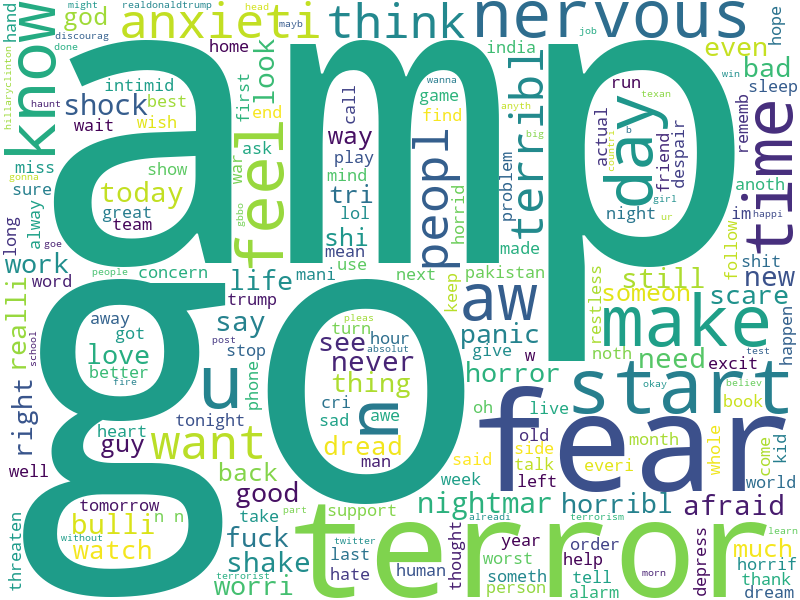

In [23]:
# Combine training data into a single string
train_text = ' '.join(mer_data_train['Tweet'].to_list())
wordcloud = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(train_text)

# Save word cloud image
wc_img_path = "figures/wordcloud_train.png"
wordcloud.to_file(wc_img_path)
img = PILImage.open(wc_img_path)
display(img)

In [24]:
y_train = to_categorical(mer_data_train['Intensity_Class'].to_numpy())
y_val = to_categorical(data_test['Intensity_Class'].to_numpy())

# Parameters
max_features = 5000
max_words = 100
batch_size = 128
epochs = 10
num_classes = 4


# Prepare training and validation data
X_train = mer_data_train['Tweet'].to_list()
X_val = data_test['Tweet'].to_list()
Y_train = y_train
Y_val = y_val

# Print shapes to verify
print(f'X_train shape: {len(X_train)}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_val shape: {len(X_val)}')
print(f'Y_val shape: {Y_val.shape}')


X_train shape: 2641
Y_train shape: (2641, 4)
X_val shape: 986
Y_val shape: (986, 4)


In [25]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_words)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_words)


#CNN Model

In [26]:
# Define the model
CNN_model = Sequential()
CNN_model.add(Embedding(max_features, 100, input_length=max_words))
CNN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(num_classes, activation='softmax'))
CNN_model.build(input_shape=(None, max_words))

# Compile the model with a smaller learning rate
CNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 612,260 (2.34 MB)

 Trainable params: 612,260 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history = CNN_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
loss, accuracy = CNN_model.evaluate(X_val_pad, y_val)
CNN_model.save("CNN_model.h5")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3828 - loss: 2.9873 - val_accuracy: 0.6420 - val_loss: 2.8269
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6148 - loss: 2.7650 - val_accuracy: 0.6420 - val_loss: 2.5762
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6238 - loss: 2.5760 - val_accuracy: 0.6420 - val_loss: 2.4269
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6422 - loss: 2.4350 - val_accuracy: 0.6420 - val_loss: 2.3325
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6336 - loss: 2.3703 - val_accuracy: 0.6420 - val_loss: 2.2409
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6505 - loss: 2.2482 - val_accuracy: 0.6420 - val_loss: 2.1582
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6434 - loss: 2.1734 - val_accuracy: 0.6420 - val_loss: 2.0862
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6478 - loss: 2.1095 - val_accuracy: 0.6420 - v

In [28]:
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

Validation Loss: 1.8959567546844482
Validation Accuracy: 0.6419878005981445


#RNN Model

In [29]:
# Define a RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, 100, input_length=max_words))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(num_classes, activation='softmax'))
rnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()
history_rnn = rnn_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
loss, accuracy = rnn_model.evaluate(X_val_pad, y_val)
rnn_model.save("Rnn_model.h5")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3896 - loss: 1.3131 - val_accuracy: 0.6420 - val_loss: 1.1332
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5944 - loss: 1.1471 - val_accuracy: 0.6420 - val_loss: 1.0537
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6400 - loss: 1.0983 - val_accuracy: 0.6420 - val_loss: 1.0468
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6499 - loss: 1.0705 - val_accuracy: 0.6420 - val_loss: 1.0376
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6622 - loss: 1.0315 - val_accuracy: 0.6420 - val_loss: 1.0382
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6613 - loss: 1.0223 - val_accuracy: 0.6420 - val_loss: 1.0422
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6629 - loss: 1.0105 - val_accuracy: 0.6420 - val_loss: 1.0411
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6492 - loss: 1.0233


#Bidirectional GRU

In [30]:
# Build the Bidirectional GRU model
model_BGRU = Sequential()
model_BGRU.add(Embedding(max_features, 100, input_length=max_words))
model_BGRU.add(SpatialDropout1D(0.25))
model_BGRU.add(Bidirectional(GRU(64, dropout=0.4, return_sequences=True)))
model_BGRU.add(Bidirectional(GRU(32, dropout=0.5, return_sequences=False)))
model_BGRU.add(Dense(num_classes, activation='sigmoid'))
# Explicitly build the model
model_BGRU.build(input_shape=(None, max_words))
model_BGRU.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model_BGRU.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
historybgru = model_BGRU.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,108 (2.27 MB)

 Trainable params: 595,108 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.4356 - loss: 0.6853 - val_accuracy: 0.6420 - val_loss: 0.6494
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.6600 - loss: 0.6366 - val_accuracy: 0.6420 - val_loss: 0.5894
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.6587 - loss: 0.5725 - val_accuracy: 0.6420 - val_loss: 0.5111
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6637 - loss: 0.4970 - val_accuracy: 0.6420 - val_loss: 0.4496
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.6643 - loss: 0.4427 - val_accuracy: 0.6420 - val_loss: 0.4338
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.6598 - loss: 0.4253 - val_accuracy: 0.6420 - val_loss: 0.4364
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.6546 - loss: 0.4305 - val_accuracy: 0.6420 - val_loss: 0.4367
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.6615 - loss: 0.4243 - val_accuracy: 0.

In [31]:
# Save Bi-directional GRU model
model_BGRU.save("model_BGRU.h5")
loss, accuracy = model_BGRU.evaluate(X_val_pad, y_val)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6492 - loss: 0.4282
Test Loss: 0.43384337425231934
Test Accuracy: 0.6419878005981445


#LSTM model

In [32]:
# For LSTM; we use dev, train, and test
y_train = to_categorical(data_train['Intensity_Class'].to_numpy())
y_val = to_categorical(data_dev['Intensity_Class'].to_numpy())
y_test = to_categorical(data_test['Intensity_Class'].to_numpy())

X_train = data_train['Tweet'].to_list()
X_val = data_dev['Tweet'].to_list()
X_test = data_test['Tweet'].to_list()

# Tokenize text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(data_test['Tweet'])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)


In [33]:
class CustomLSTMModel(Model):
    def __init__(self, max_features, embedding_dim, num_classes):
        super(CustomLSTMModel, self).__init__()
        self.embedding = Embedding(max_features, embedding_dim, mask_zero=True)
        self.lstm1 = LSTM(64, dropout=0.4, return_sequences=True)
        self.lstm2 = LSTM(32, dropout=0.5, return_sequences=False)
        self.dense = Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        return self.dense(x)

    def build_graph(self, input_shape):
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.layers.Input(shape=input_shape_nobatch)
        _ = self.call(inputs)

# Define and build the custom LSTM model
embedding_dim = 100
model3_LSTM = CustomLSTMModel(max_features, embedding_dim, num_classes)
model3_LSTM.build_graph((None, max_words))
model3_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model3_LSTM.summary()
history = model3_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)
model3_LSTM.save("model_LSTM.h5")
loss, accuracy = model3_LSTM.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Model: "custom_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,788 (2.12 MB)

 Trainable params: 554,788 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.5830 - loss: 1.3400 - val_accuracy: 0.6452 - val_loss: 1.1837
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6555 - loss: 1.0337 - val_accuracy: 0.6452 - val_loss: 1.1079
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6697 - loss: 0.8857 - val_accuracy: 0.6504 - val_loss: 1.0747
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.7306 - loss: 0.6764 - val_accuracy: 0.6170 - val_loss: 1.1241
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.7389 - loss: 0.5839 - val_accuracy: 0.6144 - val_loss: 1.1867
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.7688 - loss: 0.5220 - val_accuracy: 0.6118 - val_loss: 1.1745
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.7944 - loss: 0.4827 - val_accuracy: 0.5810 - val_loss: 1.1770
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.8224 - loss: 0.4415 - val_accuracy: 0.

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5828 - loss: 1.4683
Test Loss: 1.506693959236145
Test Accuracy: 0.5780932903289795


In [34]:
# Plot the model history
def plot_model_history(history):

# history.history dictionary to DataFrame
    history_df = pl.DataFrame({
        'epoch': range(1, len(history.history['accuracy']) + 1),
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    })

    history_df_long = history_df.melt(id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'], variable_name='type', value_name='value')
    
# Create charts
    accuracy_chart = alt.Chart(history_df_long.filter(pl.col('type').is_in(['accuracy', 'val_accuracy']))).mark_line().encode(
        x='epoch:Q',
        y='value:Q',
        color='type:N'
    ).interactive().properties(
        title='Model Accuracy'
    )
    
    loss_chart = alt.Chart(history_df_long.filter(pl.col('type').is_in(['loss', 'val_loss']))).mark_line().encode(
        x='epoch:Q',
        y='value:Q',
        color='type:N'
    ).interactive().properties(
        title='Model Loss'
    )
    
    return alt.hconcat(accuracy_chart, loss_chart)

plot_model_history(history)


alt.HConcatChart(...)

#Model Testing

In [35]:
# Test the LSTM model
predict_class=model3_LSTM.predict(X_test) 
tar_classes=np.argmax(predict_class,axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [36]:
tar_classes.tolist()

[0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 3,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 3,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
